In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image Quality Analysis using Gemini and code execution

This notebook uses the Gemini model to analyze various quality aspects of images stored in Google Cloud Storage. It fetches image URIs from a BigQuery table and then uses prompts to instruct the Gemini model to perform the following analyses:

*   **Black Blurb Percentage:** Calculates the percentage of black or near-black pixels.
*   **Resolution:** Determines the width and height of the image.
*   **Sharpness:** Calculates a sharpness score based on the variance of the Laplacian.
*   **Brightness:** Calculates the average brightness of the image.
*   **Distortion:** Provides a qualitative assessment of lens distortion.


### Sharpness Score:

```
import cv2
import numpy as np

Load the image
img_path = 'image.png'
image = cv2.imread(img_path)

 Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

 Compute the Laplacian
laplacian = cv2.Laplacian(gray, cv2.CV_64F, ksize=3)

 Calculate variance
variance = laplacian.var()

 Normalize the score to 0-100
 Assume a typical variance range from 0 to 1000.
 Linearly scale the calculated variance to fit within the 0-100 range.
 If variance > 1000, cap the score at 100.

score = (variance / 1000) * 100
if score > 100:
    score = 100

 Round to the nearest whole number
final_score = int(round(score))

```

 Print the score
print(final_score)

### Brightness:

To calculate the average brightness of the provided image, I will first convert it to grayscale and then compute the mean pixel intensity.

1.  **Grayscale Conversion:** The image is converted from its original color format to a single-channel grayscale image.
2.  **Mean Pixel Intensity Calculation:** All pixel values in the grayscale image are summed and then divided by the total number of pixels.

Using image processing tools, the average brightness (mean pixel intensity) of the original image, after converting it to grayscale, is approximately **145.54**.
Distortion: Upon analyzing the provided image, the most prominent straight line is the utility pole.

## Install required libraries

In [ ]:
!pip install --upgrade google-cloud-bigquery google-cloud-aiplatform

## Configuration

In [ ]:
PROJECT_ID = ''  # @param {type:"string"}
REGION = ''      # @param {type:"string"}
MODEL_ID = "gemini-2.5-flash" # @param {type:"string"}
BIGQUERY_TABLE = "" # @param {type:"string"}
ASSET_TYPE = "ASSET_CLASS_UTILITY_POLE" # @param {type:"string"}
LIMIT = 1 # @param {type:"integer"}

## Imports and Vertex AI Initialization

In [ ]:
import vertexai
from google.cloud import bigquery
from google import genai
from google.genai.types import (
    HttpOptions,
    Content,
    Part,
    Tool,
    ToolCodeExecution,
    GenerateContentConfig,
)
import pandas as pd
import re
import json

print("pandas, re, and json libraries have been successfully imported.")


## Fetch Image URIs from BigQuery

In [ ]:
BIGQUERY_SQL_QUERY = f"""
SELECT
  *
FROM
  `{PROJECT_ID}.{BIGQUERY_TABLE}`
   WHERE asset_type = "{ASSET_TYPE}"
LIMIT {LIMIT};
"""

try:
    bigquery_client = bigquery.Client(project=PROJECT_ID)
    query_job = bigquery_client.query(BIGQUERY_SQL_QUERY)
    query_response_data = [dict(row) for row in query_job]
    gcs_uris = [item.get("gcs_uri") for item in query_response_data if item.get("gcs_uri")]
    print(f"Successfully fetched {len(gcs_uris)} GCS URIs:")
    for uri in gcs_uris:
        print(uri)
except Exception as e:
    print(f"An error occurred while querying BigQuery: {e}")

## Define Analysis Prompts

In [50]:
PROMPT_BLACK_BLURB = """Analyze the provided image and calculate the percentage of black or near-black pixels (pixels with an intensity less than 10 out of 255). Provide only the final percentage as a float."""
PROMPT_RESOLUTION = """Analyze the provided image and determine its resolution. Provide the output as a JSON object with 'width' and 'height' keys."""
PROMPT_SHARPNESS = """You will be provided with an image for analysis.

Your task is to calculate a sharpness score for this image by writing and executing code. Follow these steps exactly:

Load the Image: Access the provided image file.
Convert to Grayscale: Convert the color image into a single-channel grayscale image. This is a necessary preprocessing step for the Laplacian operator.
Compute the Laplacian: Apply the Laplacian operator to the grayscale image. Use a 3x3 kernel for this operation (e.g., cv2.Laplacian in OpenCV with ksize=3).
Calculate Variance: Compute the variance of the resulting Laplacian matrix. The variance value is the raw sharpness metric.
Normalize the Score: Map the calculated variance to a normalized score from 0 to 100.
Assume a typical variance range for images is from 0 (blurry) to 1000 (very sharp).
Linearly scale the calculated variance to fit within the 0-100 range. For example, a variance of 500 would map to a score of 50.
If the calculated variance is greater than 1000, the final score should be capped at 100.
Format the Output: Your final output must be ONLY the calculated sharpness score, rounded to the nearest whole number (integer). Do not include any other text, explanation, or code."""
PROMPT_BRIGHTNESS = """Analyze the provided image and calculate its average brightness. Convert the image to grayscale and find the mean pixel intensity. Provide the result as a float between 0 and 255."""
PROMPT_DISTORTION = """Analyze the provided image for lens distortion. Detect straight lines in the image and assess their curvature. Provide a qualitative assessment, such as 'Low distortion detected' or 'Potential distortion or lack of straight lines'."""

## Run Analysis

In [ ]:
# Initialize the genai Client and the code execution Tool
client = genai.Client(vertexai=True, project=PROJECT_ID, location=REGION)
code_execution_tool = Tool(code_execution=ToolCodeExecution())

def analyze_image(gcs_uri: str, prompt: str) -> str:
    """Analyzes an image from GCS using the Gemini model with code execution, returning None on error."""
    try:
        contents = [
            prompt,
            Part(file_data={'file_uri': gcs_uri, 'mime_type': 'image/jpeg'})
        ]
        # Update the generate_content call to include the code execution tool
        response = client.models.generate_content(
            model=MODEL_ID,
            contents=contents,
            config=GenerateContentConfig(
            tools=[code_execution_tool],
            temperature=0,
              )
        )
        return response.text
    except Exception as e:
        print(f"Error analyzing '{gcs_uri}': {e}")
        return None

results = []

if 'query_response_data' in locals() and query_response_data:
    for item in query_response_data:
        asset_id = item.get("asset_id")
        uri = item.get("gcs_uri")

        if not uri or not asset_id:
            continue

        print(f"--- Analyzing {uri} ---")

        # Analyze image with all prompts
        black_blurb_response = analyze_image(uri, PROMPT_BLACK_BLURB)
        resolution_response = analyze_image(uri, PROMPT_RESOLUTION)
        sharpness_response = analyze_image(uri, PROMPT_SHARPNESS)
        brightness_response = analyze_image(uri, PROMPT_BRIGHTNESS)
        distortion_response = analyze_image(uri, PROMPT_DISTORTION)

        # Parse results, now robust to None responses from analyze_image
        try:
            black_blurb_percentage = float(re.search(r'[-+]?\d*\.?\d+', black_blurb_response).group())
        except (ValueError, AttributeError, TypeError):
            black_blurb_percentage = None

        width, height = None, None
        try:
            json_match = re.search(r'```json\s*(\{.*?\})\s*```', resolution_response, re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
            else:
                start_index = resolution_response.find('{')
                end_index = resolution_response.rfind('}') + 1
                if start_index != -1 and end_index != 0:
                    json_str = resolution_response[start_index:end_index]
                else:
                    raise ValueError("No JSON found")
            resolution_data = json.loads(json_str)
            width = int(resolution_data['width'])
            height = int(resolution_data['height'])
        except (json.JSONDecodeError, AttributeError, KeyError, TypeError, ValueError):
            width, height = None, None

        try:
            sharpness_score = int(float(re.search(r'[-+]?\d*\.?\d+', sharpness_response).group()))
        except (ValueError, AttributeError, TypeError):
            sharpness_score = None

        try:
            numbers = re.findall(r'[-+]?\d*\.?\d+', brightness_response)
            brightness = float(numbers[-1]) if numbers else None
        except (ValueError, AttributeError, TypeError):
            brightness = None

        distortion_assessment = distortion_response.strip() if distortion_response else None

        # Store results
        result_item = {
            "asset_id": asset_id,
            "black_blurb_percentage": black_blurb_percentage,
            "width": width,
            "height": height,
            "sharpness_score": sharpness_score,
            "brightness": brightness,
            "distortion": distortion_assessment
        }
        results.append(result_item)

    # Create and display DataFrame
    if results:
        df = pd.DataFrame(results)
        df.set_index('asset_id', inplace=True)
        print("\n--- Analysis Results ---")
        display(df)
    else:
        print("No data to display.")

else:
    print("No GCS URIs were found to analyze.")

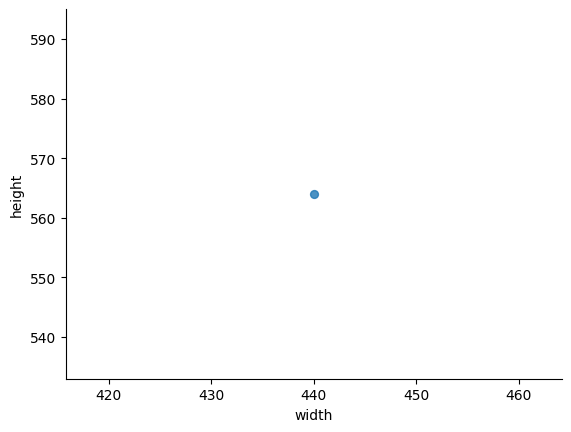

In [52]:
from matplotlib import pyplot as plt
df.plot(kind='scatter', x='width', y='height', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)